
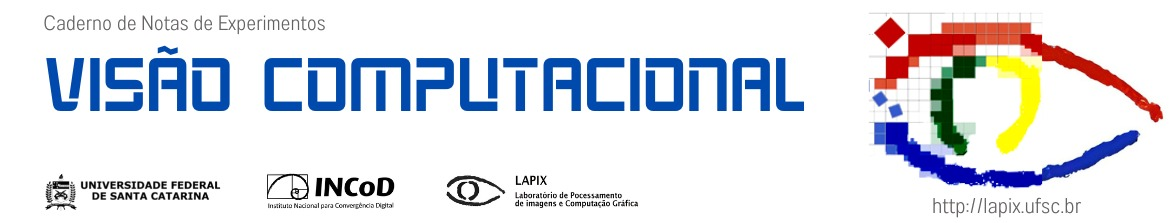






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/02.4.Dom%C3%ADnio%20do%20Valor%20-%20Filtros%20de%20Histograma.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

# 02.4.Domínio do Valor - Filtros de Histograma

A ideia dos filtros de histograma é tomar a distribuição de tons de cinza ou de cores de uma imagem (afinal, a não ser que você tenha uma imagem onde o valor de cor é um Float, são valores inteiros e trata-se de uma distribuição discreta em um conjunto claramente definido de valores) e usá-la. 


# Configurações GPU e PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

## Global Histogram Equalization

Referências: 
* https://en.wikipedia.org/wiki/Histogram_equalization
* http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm
* https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
* https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

import cv2

In [2]:
matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256, cdf=False):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    if cdf:
        ax_cdf.plot(bins, img_cdf, 'r')
        ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


In [3]:
# Load an example image
img = data.moon()
print('Image size:', img.shape)

Image size: (512, 512)


In [4]:
def stretch(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return(img_rescale)

def equalize(img): 
    # Equalization
    img_eq = exposure.equalize_hist(img)
    return(img_eq)

def equalize_adapt(img):
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return(img_adapteq)

def display_global_equalizations(img, img_rescale, img_eq, img_adapteq, cdf=False):
    # Display results
    fig = plt.figure(figsize=(14, 10))
    axes = np.zeros((2, 4), dtype=object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0], cdf=cdf)
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1], cdf=cdf)
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2], cdf=cdf)
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3], cdf=cdf)
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

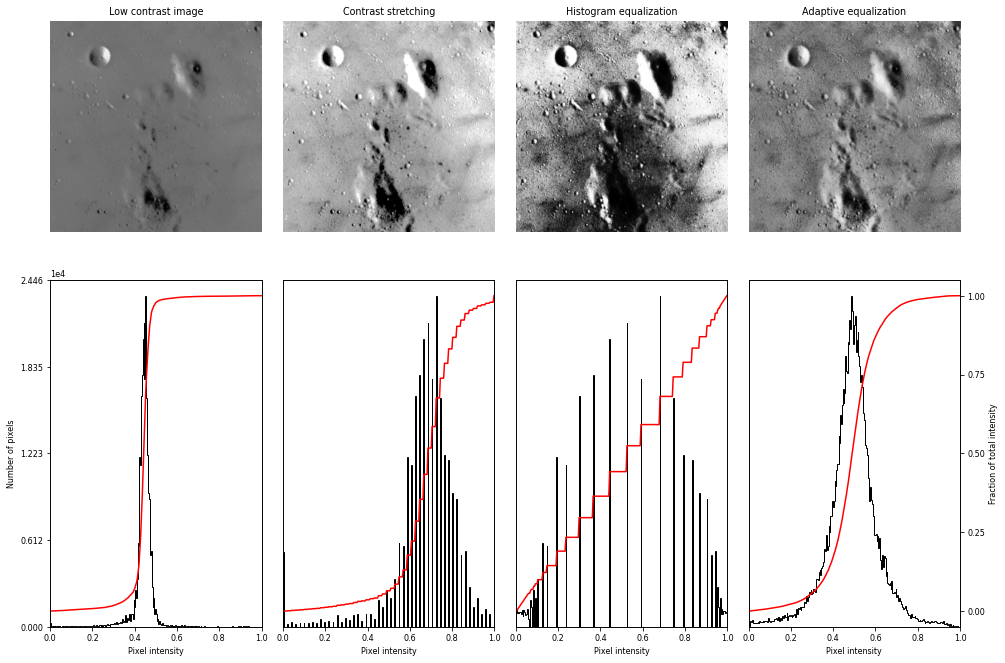

In [5]:
img_rescale = stretch(img)
img_eq = equalize(img)
img_adapteq = equalize_adapt(img)
display_global_equalizations(img, img_rescale, img_eq, img_adapteq, cdf=True)

## Local Histogram Equalization

In [6]:
# Local histogram-specific imports from skimage
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank

# Local histogram-specific functions

def global_equalize(img):
    # Global equalize
    img_rescale = exposure.equalize_hist(img)
    return(img_rescale)

def local_equalize(img, disksize):
    # Local Equalization
    selem = disk(disksize)
    img_eq = rank.equalize(img, selem=selem)
    return(img_eq)

def display_equalizations(img, img_rescale, img_eq, cdf=False):
    # Display results
    fig = plt.figure(figsize=(14, 10))
    axes = np.zeros((2, 3), dtype=object)
    axes[0, 0] = plt.subplot(2, 3, 1)
    axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
    axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
    axes[1, 0] = plt.subplot(2, 3, 4)
    axes[1, 1] = plt.subplot(2, 3, 5)
    axes[1, 2] = plt.subplot(2, 3, 6)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0], cdf=cdf)
    ax_img.set_title('Low contrast image')
    ax_hist.set_ylabel('Number of pixels')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1], cdf=cdf)
    ax_img.set_title('Global equalise')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2], cdf=cdf)
    ax_img.set_title('Local equalize')
    ax_cdf.set_ylabel('Fraction of total intensity')


    # prevent overlap of y-axis labels
    fig.tight_layout()

Disk kernel size =   51


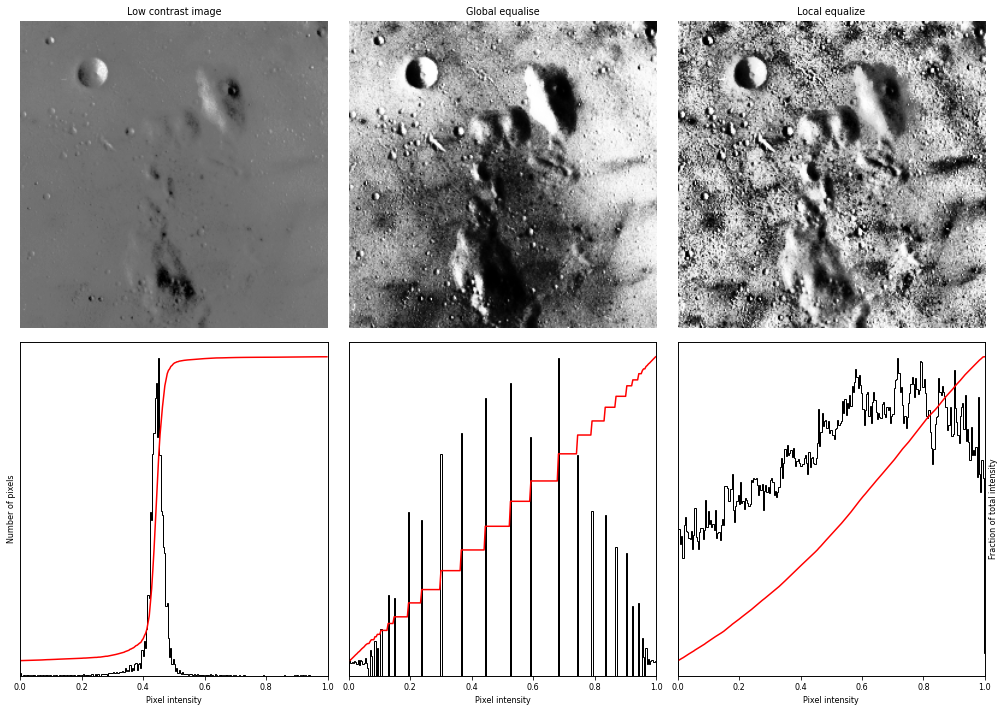

In [7]:
# Test for a standard image

img_rescale = global_equalize(img)

# Use a disk-shaped kernel for the definition of locality
# A good estimation for the disk size is 10% of the image height
disk_kernel_size = int(img.shape[0] * 0.1)
print('Disk kernel size =  ', disk_kernel_size)
img_eq = local_equalize(img, disk_kernel_size)

# Show the results
display_equalizations(img, img_rescale, img_eq, cdf=True)

## Test with an old glassplate photograph from Santa Catarina Island

In [8]:
# Load an old glassplate photograph from Santa Catarina Island
foto = cv2.imread('../data/praca.jpg',0)
print('Image size:', foto.shape)

Image size: (624, 828)


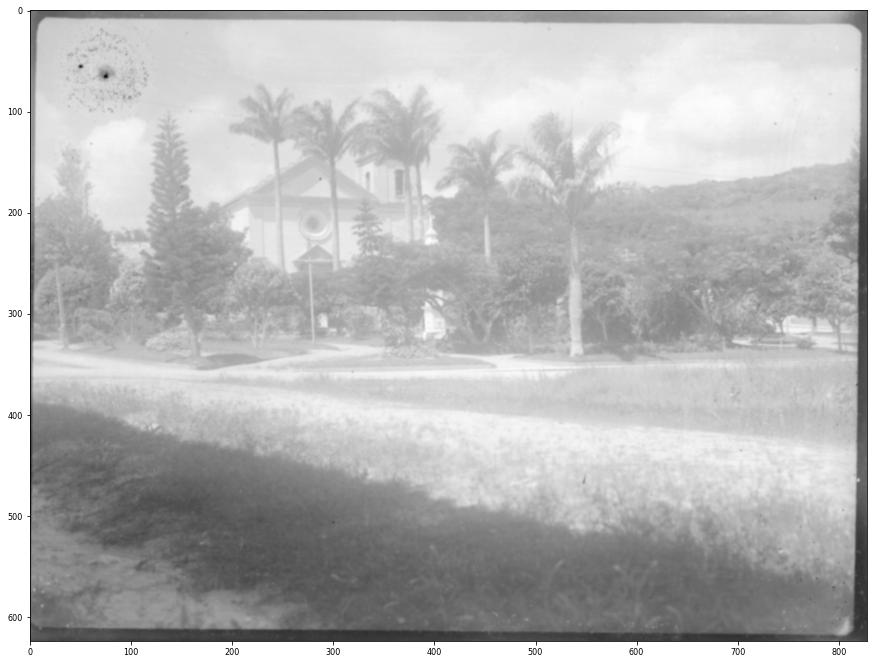

In [9]:
# Show image
fig = plt.figure(figsize=(15, 12))
plt.imshow(foto, cmap = 'gray', interpolation = 'bicubic')
plt.show()

### Global

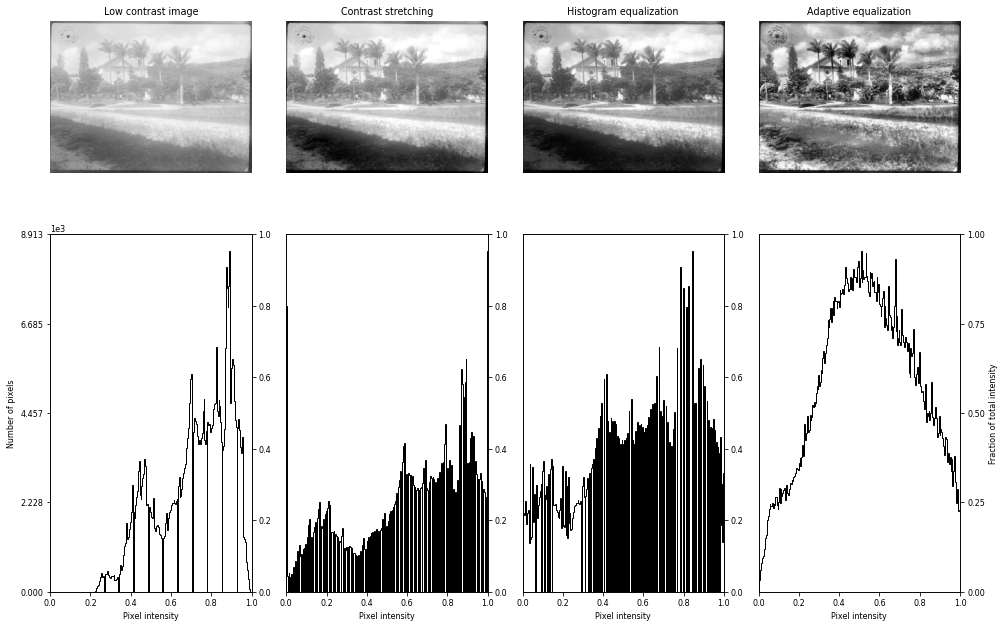

In [10]:
# Global histoeq
img_rescale = stretch(foto)
img_eq = equalize(foto)
img_adapteq = equalize_adapt(foto)
display_global_equalizations(foto, img_rescale, img_eq, img_adapteq)

### Local

Disk kernel size =   62


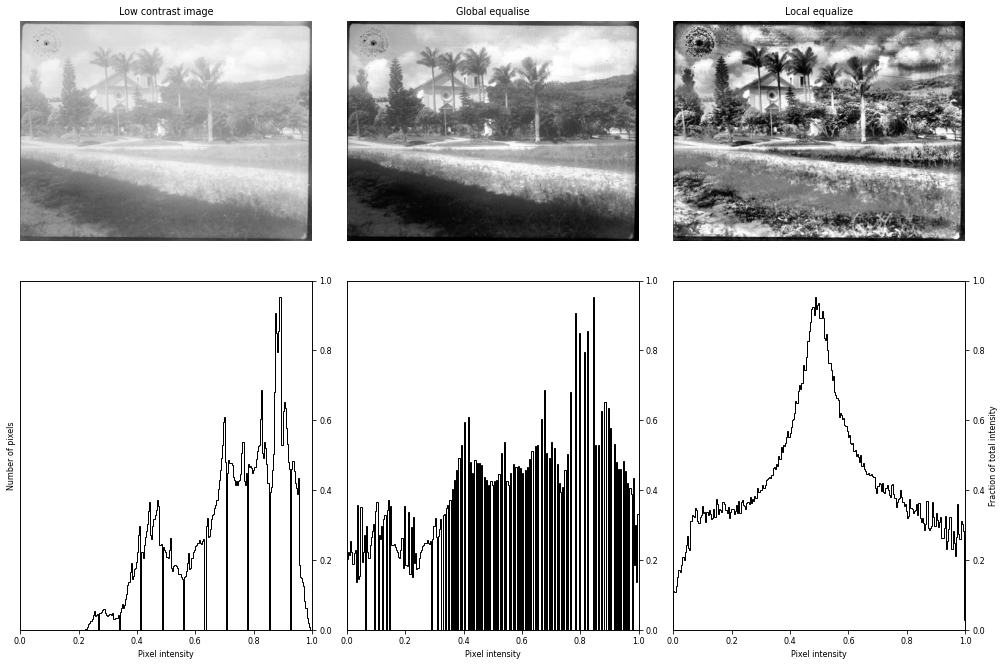

In [11]:
# Local histoeq
img_rescale = global_equalize(foto)

# Use a disk-shaped kernel for the definition of locality
# A good first estimation for the disk size is 10% of the 
# image height. You can then test with larger sizes...
disk_kernel_size = int(foto.shape[0] * 0.1)
print('Disk kernel size =  ', disk_kernel_size)
img_eq = local_equalize(foto, disk_kernel_size)

# Show the results
display_equalizations(foto, img_rescale, img_eq, cdf=False)

### Compare Disk Sizes

<ipython-input-12-0420ae7d53cb>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 2), dtype=np.object)


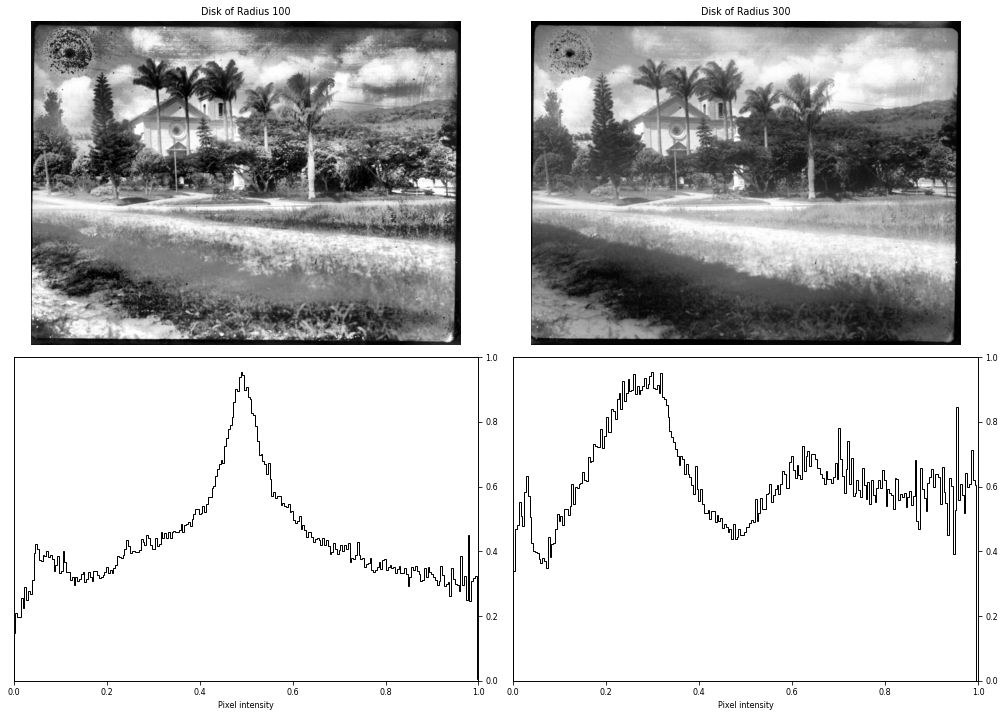

In [12]:
img_eq1 = local_equalize(foto, 100)
img_eq2 = local_equalize(foto, 300)

fig = plt.figure(figsize=(14, 10))
axes = np.zeros((2, 2), dtype=np.object)
axes[0, 0] = plt.subplot(2, 2, 1)
axes[0, 1] = plt.subplot(2, 2, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 2, 3)
axes[1, 1] = plt.subplot(2, 2, 4)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq1, axes[:, 0])
ax_img.set_title('Disk of Radius 100')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq2, axes[:, 1])
ax_img.set_title('Disk of Radius 300')

# prevent overlap of y-axis labels
fig.tight_layout()


### Compare Local and Adaptive Equalizations

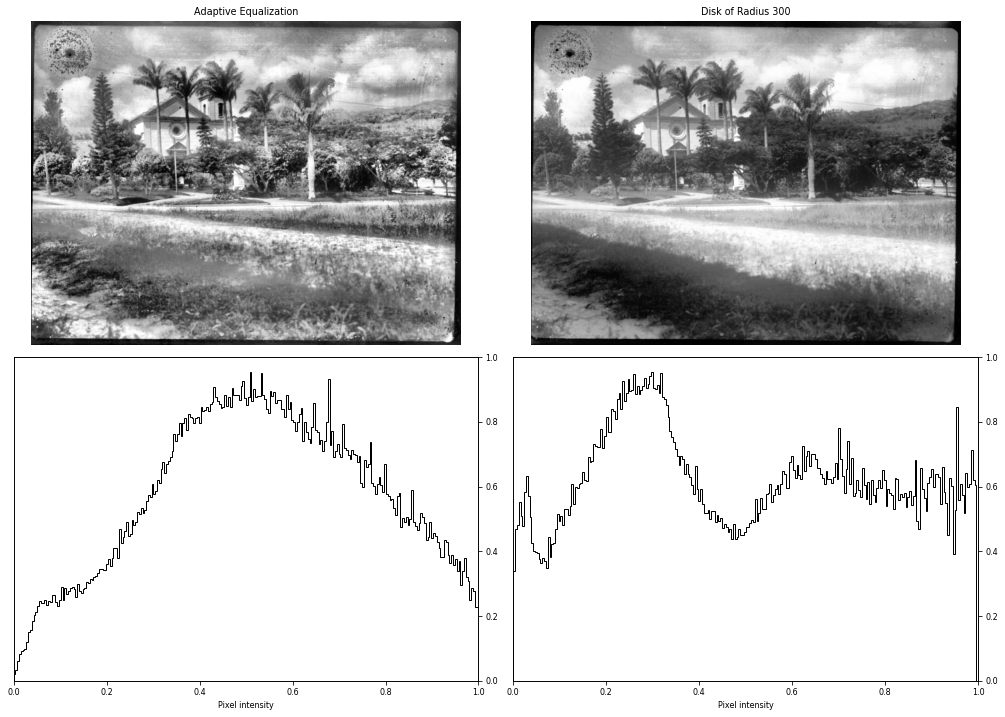

In [14]:
fig = plt.figure(figsize=(14, 10))
axes = np.zeros((2, 2), dtype=object)
axes[0, 0] = plt.subplot(2, 2, 1)
axes[0, 1] = plt.subplot(2, 2, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 2, 3)
axes[1, 1] = plt.subplot(2, 2, 4)

cdf = True
cdf = False

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 0], cdf=cdf)
ax_img.set_title('Adaptive Equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq2, axes[:, 1], cdf=cdf)
ax_img.set_title('Disk of Radius 300')

# prevent overlap of y-axis labels
fig.tight_layout()

![rodape lapix ufsc](../rodape-CC.png)